In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [12]:
# Function to load and preprocess MFCC heatmap images
def load_mfcc_images_from_directory(directory):
    image_data = []
    labels = []
    label_to_index = {'Bonafide': 0, 'Fake': 1}  # Define labels
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            if image_file.endswith('.png'):
                img = image.load_img(os.path.join(label_path, image_file), target_size=(299, 299))
                img_array = image.img_to_array(img)
                image_data.append(img_array)
                labels.append(label_to_index[label])

    image_data = np.array(image_data)
    labels = np.array(labels)
    return image_data, labels

In [13]:
# Load data
data_dir = "./DATASETS/processed_latest/Subset_Heatmaps"

In [14]:
X, y = load_mfcc_images_from_directory(data_dir)

In [15]:
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
# Define the Xception model
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Function to train the model with progress print
def train_model(model, X_train, y_train, X_val, y_val, epochs=10):
    checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6, mode='max', verbose=1)
    history = History()

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[checkpoint, early_stopping, reduce_lr, history])

    # Display progress
    history_df = pd.DataFrame(history.history)
    print(history_df)

    return model

In [16]:
# Function to evaluate the model and print performance metrics
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    y_pred = np.argmax(model.predict(X_test), axis=-1)

    class_names = ['Bonafide', 'Fake']
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print("Performance Metrics:")
    print(df)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)


In [ ]:
# Train, validate, and evaluate the model
trained_model = create_xception_model()
trained_model = train_model(trained_model, X_train, y_train, X_val, y_val)
evaluate_model(trained_model, X_test, y_test)

Epoch 1/10
184/184 [==============================] - ETA: 0s - loss: 3.8127 - accuracy: 0.5354
Epoch 1: val_accuracy improved from -inf to 0.58038, saving model to model.h5
184/184 [==============================] - 1051s 6s/step - loss: 3.8127 - accuracy: 0.5354 - val_loss: 1.2139 - val_accuracy: 0.5804 - lr: 1.0000e-04
Epoch 2/10
184/184 [==============================] - ETA: 0s - loss: 1.3144 - accuracy: 0.5702
Epoch 2: val_accuracy improved from 0.58038 to 0.63896, saving model to model.h5
184/184 [==============================] - 861s 5s/step - loss: 1.3144 - accuracy: 0.5702 - val_loss: 0.7312 - val_accuracy: 0.6390 - lr: 1.0000e-04
Epoch 3/10
184/184 [==============================] - ETA: 0s - loss: 1.4867 - accuracy: 0.5648
Epoch 3: val_accuracy did not improve from 0.63896
184/184 [==============================] - 814s 4s/step - loss: 1.4867 - accuracy: 0.5648 - val_loss: 2.4382 - val_accuracy: 0.5102 - lr: 1.0000e-04
Epoch 4/10
184/184 [==============================] - 

In [64]:
model_path = 'model.h5'

# Load the model
loaded_model = load_model(model_path)

# Summary of the loaded model
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [6]:
def plot_confusion_matrix(y_true, y_pred, target_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [17]:
# Evaluate the model on the test set
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

58/58 [==============================] - 276s 5s/step - loss: 0.6129 - accuracy: 0.7056
Test Accuracy: 0.705561637878418
Test Loss: 0.6128667593002319


In [42]:
# Classification Report
# y_pred_classes = np.argmax(y_pred)
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       914
           1       0.67      0.80      0.73       920

    accuracy                           0.71      1834
   macro avg       0.71      0.71      0.70      1834
weighted avg       0.71      0.71      0.70      1834



In [41]:
y_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [43]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_classes:", y_pred.shape)

Shape of y_test: (1834,)
Shape of y_pred_classes: (1834,)


In [57]:
y_scores = loaded_model.predict(X_test)

58/58 [==============================] - 274s 5s/step


In [59]:
y_scores_np = np.argmax(y_scores)

In [60]:
y_scores_np

3543

In [58]:
y_scores

array([[0.25794977, 0.74205023],
       [0.98228294, 0.01771701],
       [0.01657067, 0.9834293 ],
       ...,
       [0.91712606, 0.08287401],
       [0.0272686 , 0.9727314 ],
       [0.8835227 , 0.11647733]], dtype=float32)

In [63]:
y_scores_1d = y_scores[:, 1]

In [65]:
y_scores_1d

array([0.74205023, 0.01771701, 0.9834293 , ..., 0.08287401, 0.9727314 ,
       0.11647733], dtype=float32)

In [69]:
y_test

array([1, 1, 1, ..., 0, 0, 0])

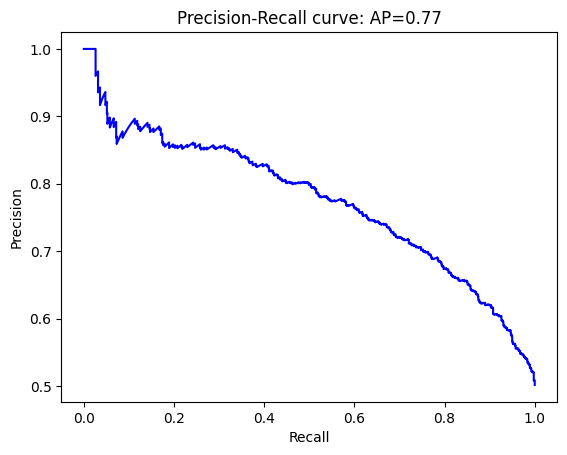

In [70]:
# Compute precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_scores_1d)
average_precision = average_precision_score(y_test, y_scores_1d)

# Plot precision-recall curve
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

58/58 [==============================] - 277s 5s/step


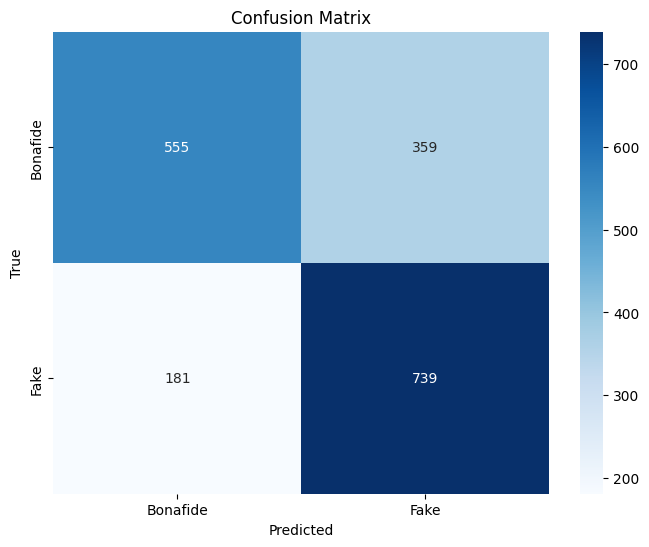

In [16]:
# Plot confusion matrix
y_pred = np.argmax(loaded_model.predict(X_test), axis=-1)
class_names = ['Bonafide', 'Fake']
plot_confusion_matrix(y_test, y_pred, class_names)

In [3]:
# Function to extract MFCC features and save as heatmap
def extract_mfcc(file_path, output_directory):
    y, sr = librosa.load(file_path)  # Load audio file
    num_mfcc = 40  # Set the number of MFCC coefficients
    n_fft = 1024  # Set the FFT window size
    hop_length = 256  # Set the hop length
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # Transpose the MFCC matrix

    # Plotting the MFCC as a heatmap
    plt.figure(figsize=(15, 10))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC Heatmap')

    # Check if the output directory exists, if not, create it
    os.makedirs(output_directory, exist_ok=True)

    # Save the MFCC heatmap
    output_path = os.path.join(output_directory, os.path.basename(file_path) + '_mfcc.png')
    plt.savefig(output_path)
    plt.close()
    return mfcc

In [69]:
import librosa
from tensorflow.keras.applications.xception import preprocess_input
# Load the audio file
audio_file_path = "D:/Sailu/Academics/BE/Major Project A/Deepfake_audio_detection/DATASETS/processed_latest/Subset/Fake/LJ001-0004_ljspeech_waveglow.wav"

# Extract MFCC features and save as a heatmap
mfcc_features = extract_mfcc(audio_file_path, output_directory='./DATASETS/TEST_Fake_mfcc')

In [71]:
# Load the MFCC heatmap image
mfcc_image_path = "D:/Sailu/Academics/BE/Major Project A/Deepfake_audio_detection/DATASETS/TEST_Fake_mfcc/LJ001-0004_ljspeech_waveglow.wav_mfcc.png"
# Load the image and preprocess it for Xception model input
img = image.load_img(mfcc_image_path, target_size=(299, 299))  # Xception model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

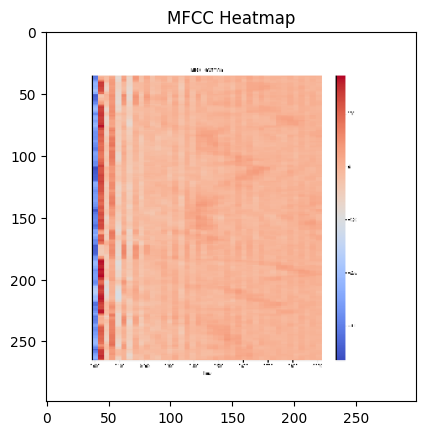

1/1 [==============================] - 2s 2s/step
The audio is classified as: Fake


In [72]:
# Display the MFCC heatmap
plt.imshow(img)
plt.title('MFCC Heatmap')
plt.show()

# Make a prediction using the loaded Xception model
prediction = loaded_model.predict(img_array)

# Assuming the model predicts the probability of being "fake" (binary classification)
result = "Fake" if prediction[0][0] > 0.5 else "Bonafide"

print(f"The audio is classified as: {result}")

In [74]:
import librosa
from tensorflow.keras.applications.xception import preprocess_input
# Load the audio file
audio_file_path = "D:/Sailu/Academics/BE/Major Project A/Deepfake_audio_detection/DATASETS/processed_latest/Subset/Bonafide/LJ001-0004.wav"

# Extract MFCC features and save as a heatmap
mfcc_features = extract_mfcc(audio_file_path, output_directory='./DATASETS/TEST_mfcc')

In [75]:
# Load the MFCC heatmap image
mfcc_image_path = "D:/Sailu/Academics/BE/Major Project A/Deepfake_audio_detection/DATASETS/TEST_mfcc/LJ001-0004.wav_mfcc.png"
# Load the image and preprocess it for Xception model input
img = image.load_img(mfcc_image_path, target_size=(299, 299))  # Xception model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

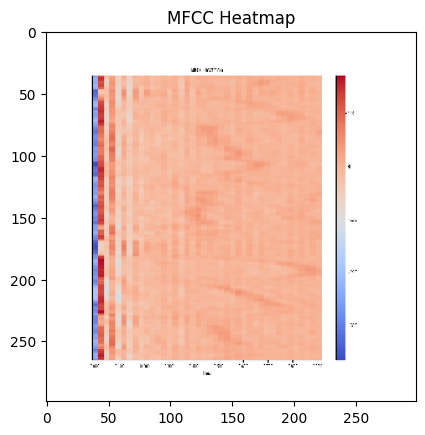

1/1 [==============================] - 0s 277ms/step
The audio is classified as: Bonafide


In [76]:
# Display the MFCC heatmap
plt.imshow(img)
plt.title('MFCC Heatmap')
plt.show()

# Make a prediction using the loaded Xception model
prediction = loaded_model.predict(img_array)

# Assuming the model predicts the probability of being "fake" (binary classification)
result = "Fake" if prediction[0][0] > 0.5 else "Bonafide"

print(f"The audio is classified as: {result}")